In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

import torch
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

from models import EdgeEncoder, EdgeDecoder

/sciclone/geograd/stmorse/sgg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_path = '/sciclone/geograd/stmorse/reddit/subreddit/science/filtered'

In [3]:
start_year, end_year = 2007, 2011
start_month, end_month = 1, 12
period = 6

graphs = {}
features = {}

current_key = 0
for year in range(start_year, end_year + 1):
    for month in range(start_month, end_month + 1, period):
        end_period_month = month + period - 1
        end_period_year = year
        if end_period_month > 12:
            end_period_month -= 12
            end_period_year += 1
        if end_period_year > end_year or (end_period_year == end_year and end_period_month > end_month):
            break

        graph_file = f"graph_{year}-{month:02d}_{end_period_year}-{end_period_month:02d}_filtered.json"
        feature_file = f"features_{year}-{month:02d}_{end_period_year}-{end_period_month:02d}_filtered.npy"

        graph_path = os.path.join(input_path, graph_file)
        feature_path = os.path.join(input_path, feature_file)

        if os.path.exists(graph_path):
            with open(graph_path, 'r') as f:
                graphs[current_key] = json.load(f)

        if os.path.exists(feature_path):
            features[current_key] = np.load(feature_path)

        current_key += 1

# visualize co-reply and feature graphs

H: nodes 54 edges 60


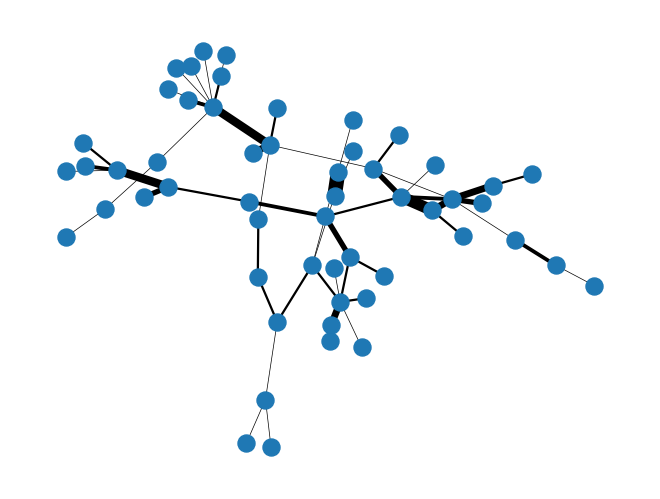

In [11]:
key = 0  # specify the key you want to convert

graph_data = graphs[key]
G = nx.Graph()  # create a graph

# Add nodes
user_to_idx = graph_data['user_to_idx']
for user, idx in user_to_idx.items():
    G.add_node(idx, user=user)

# Add edges
edge_index = graph_data['edge_index']
edge_weights = graph_data['edge_weight']
for i, (src, dst) in enumerate(zip(edge_index[0], edge_index[1])):
    G.add_edge(src, dst, weight=edge_weights[i])

# Filter edges based on weight threshold
weight_threshold = 2
edges_to_keep = [(u, v) for u, v, attr in G.edges(data=True) if attr['weight'] > weight_threshold]
H = G.edge_subgraph(edges_to_keep).copy()

# keep just largest connected component
# largest_cc = max(nx.connected_components(G), key=len)
# H = G.subgraph(largest_cc)
largest_cc = max(nx.connected_components(H), key=len)
H = H.subgraph(largest_cc)

print(f"H: nodes {H.number_of_nodes()} edges {H.number_of_edges()}")

# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Extract weights from each edge in the component
weights = [H[u][v]['weight'] for u, v in H.edges()]

# Optionally, scale edge widths (this scales weights between 0.5 and 5)
min_w, max_w = min(weights), max(weights)
scale = 10 / (max_w - min_w) if max_w != min_w else 1
edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

# Draw the graph with edge widths proportional to their weight
nx.draw(H, pos, with_labels=False, node_size=150, width=edge_widths)
plt.show()

0: nodes 2144 edges 1013
1: nodes 2144 edges 3639


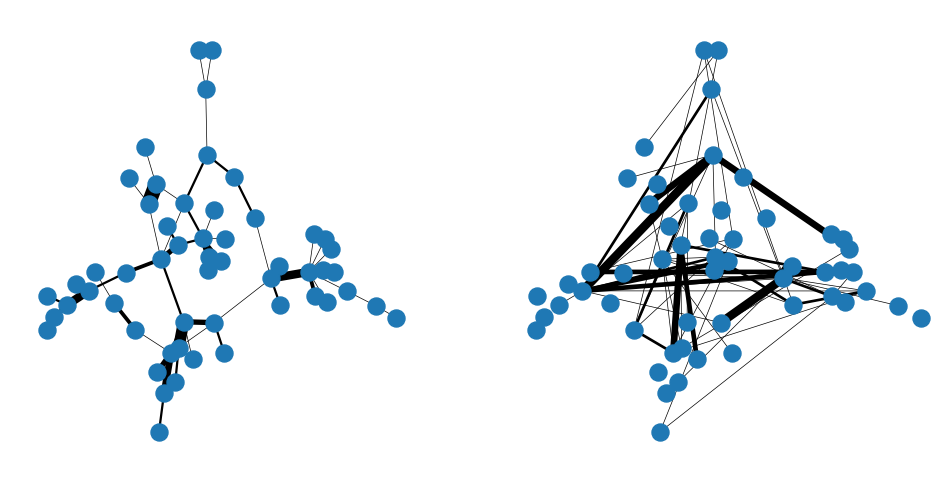

In [12]:
keys = [0, 1]  # specify the keys you want to convert
weight_threshold = 2

Gs = {key: nx.Graph() for key in keys}

# do full graphs
for key in keys:
    user_to_idx = graphs[key]['user_to_idx']
    for user, idx in user_to_idx.items():
        Gs[key].add_node(idx, user=user)

    # Add edges
    edge_index = graphs[key]['edge_index']
    edge_weights = graphs[key]['edge_weight']
    for i, (src, dst) in enumerate(zip(edge_index[0], edge_index[1])):
        Gs[key].add_edge(src, dst, weight=edge_weights[i])

    print(f"{key}: nodes {Gs[key].number_of_nodes()} edges {Gs[key].number_of_edges()}")

# filter first graph
# Filter edges based on weight threshold
# and keep just largest connected component
key = keys[0]
edges_to_keep = [(u, v) for u, v, attr in Gs[key].edges(data=True) if attr['weight'] > weight_threshold]
Gs[key] = Gs[key].edge_subgraph(edges_to_keep)
largest_cc = max(nx.connected_components(Gs[key]), key=len)
Gs[key] = Gs[key].subgraph(largest_cc)

# filter second graph based off first
nodes_to_keep = set(Gs[keys[0]].nodes())
Gs[keys[1]] = Gs[keys[1]].subgraph(nodes_to_keep).copy()

# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(Gs[keys[0]], seed=42)

fig, axs = plt.subplots(1,2, figsize=(12,6))

for ax, key in zip(axs, keys):
    H = Gs[key]
    
    # Extract weights from each edge in the component
    weights = [H[u][v]['weight'] for u, v in H.edges()]

    # Optionally, scale edge widths (this scales weights between 0.5 and 5)
    min_w, max_w = min(weights), max(weights)
    scale = 10 / (max_w - min_w) if max_w != min_w else 1
    edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

    # Draw the graph with edge widths proportional to their weight
    nx.draw(H, pos, with_labels=False, node_size=150, width=edge_widths, ax=ax)

plt.show()

(54, 15) (54, 15)


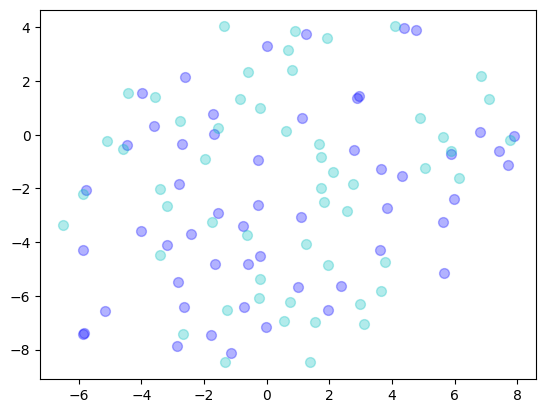

In [15]:
n = len(nodes_to_keep)
x0 = features[keys[0]][list(nodes_to_keep),:]
x1 = features[keys[1]][list(nodes_to_keep),:]
print(x0.shape, x1.shape)

x = np.vstack((x0, x1))
xt = TSNE(n_components=2).fit_transform(x)

plt.scatter(xt[:n,0], xt[:n,1], c='b', s=50, alpha=0.3)
plt.scatter(xt[n:,0], xt[n:,1], c='c', s=50, alpha=0.3)
plt.show()

In [22]:
Hs = {key: nx.Graph() for key in keys}
threshold = 0.8

for key in keys:
    Hs[key].add_nodes_from(nodes_to_keep)

    ntk = list(nodes_to_keep)
    sim_mx = cosine_similarity(features[key][ntk,:])

    for i in range(len(ntk)):
        for j in range(i + 1, len(ntk)):  # Avoid duplicate edges
            if sim_mx[i, j] > threshold:
                Hs[key].add_edge(ntk[i], ntk[j], weight=sim_mx[i, j])

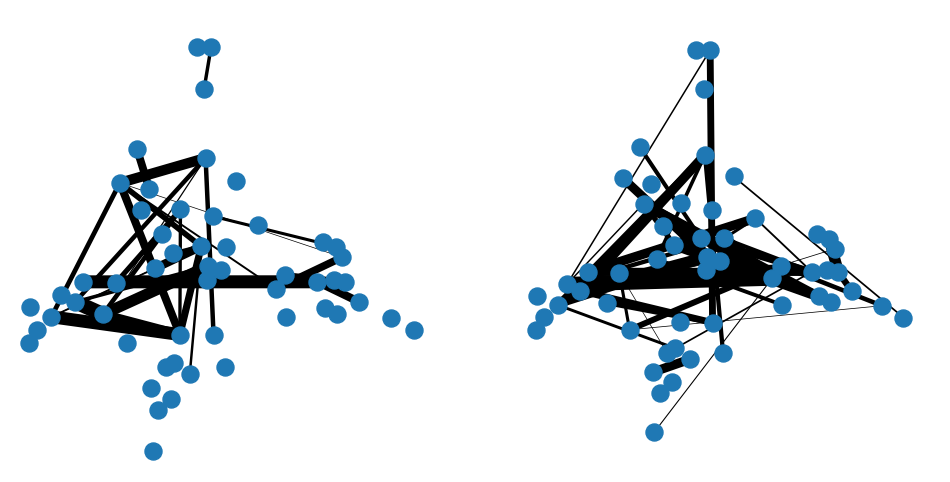

In [23]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

for ax, key in zip(axs, keys):
    H = Hs[key]
    
    # Extract weights from each edge in the component
    weights = [H[u][v]['weight'] for u, v in H.edges()]

    # Optionally, scale edge widths (this scales weights between 0.5 and 5)
    min_w, max_w = min(weights), max(weights)
    scale = 10 / (max_w - min_w) if max_w != min_w else 1
    edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

    # Draw the graph with edge widths proportional to their weight
    nx.draw(H, pos, with_labels=False, node_size=150, width=edge_widths, ax=ax)

plt.show()

# check similarity of co-reply and feature graphs

In [14]:
def compute_auc(graph_data, feature_matrix):
    # Helper function to compute cosine similarity between two vectors
    def cosine_sim(vec1, vec2):
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    # Extract graph data
    edge_index = graph_data['edge_index']
    num_nodes = feature_matrix.shape[0]

    # Prepare labels and predictions
    labels = []
    predictions = []

    # Positive edges
    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]
    labels.extend([1] * len(src_nodes))  # Positive edges
    predictions.extend(cosine_similarity(feature_matrix[src_nodes], feature_matrix[dst_nodes]).diagonal())

    # Negative edges (non-existent edges)
    all_pairs = np.array(np.meshgrid(range(num_nodes), range(num_nodes))).T.reshape(-1, 2)
    existing_edges = set(zip(edge_index[0], edge_index[1]))
    negative_edges = [pair for pair in all_pairs if pair[0] != pair[1] and tuple(pair) not in existing_edges]

    negative_edges = np.array(negative_edges)
    labels.extend([0] * len(negative_edges))  # Negative edges
    predictions.extend(cosine_similarity(feature_matrix[negative_edges[:, 0]], feature_matrix[negative_edges[:, 1]]).diagonal())

    # Compute AUC (ROC) score
    auc_score = roc_auc_score(labels, predictions)
    return auc_score

# visualize latent space

In [24]:
def get_edge_latents(graph_json_path, feature_npy_path, model_pth_path, device='cpu'):
    """
    Returns:
      edge_index: torch.LongTensor of shape [2, E], the (u,v) pairs
      z_uv:       np.ndarray of shape [E, latent_dim], edge embeddings
      scores:     np.ndarray of shape [E], decoder’s edge-existence probabilities
    """
    # 1) Load graph & features
    with open(graph_json_path, 'r') as f:
        g = json.load(f)
    edge_index = torch.tensor(g['edge_index'], dtype=torch.long, device=device)
    x = torch.tensor(np.load(feature_npy_path), dtype=torch.float, device=device)

    # 2) Instantiate & load model
    num_nodes, in_dim = x.shape
    encoder     = EdgeEncoder(in_channels=in_dim, hidden_channels=64, edge_latent_dim=32).to(device)
    # edge_decoder= EdgeDecoder(edge_latent_dim=32).to(device)
    ckpt = torch.load(model_pth_path, map_location=device)
    encoder.load_state_dict(ckpt['enc'])
    # edge_decoder.load_state_dict(ckpt['ed'])
    
    encoder.eval(); 
    # edge_decoder.eval()

    # 3) Node‐level encoding
    h = F.relu(encoder.gcn1(x, edge_index, None))
    h = F.relu(encoder.gcn2(h, edge_index, None))

    # 4) Build edge embeddings
    src, dst = edge_index
    z_input = torch.cat([h[src], h[dst]], dim=1)
    z_uv = encoder.edge_mlp(z_input)

    # 5) Decode edge scores
    # with torch.no_grad():
    #     scores = edge_decoder(z_uv)

    return edge_index.cpu(), z_uv.detach().cpu().numpy(), 
        # scores.cpu().numpy()

In [25]:
def sample_negative_edges(num_nodes, pos_set, num_samples, device):
    neg = set()
    while len(neg) < num_samples:
        cand = torch.randint(0, num_nodes, (num_samples*2, 2), device=device).tolist()
        for u, v in cand:
            if u == v or (u,v) in pos_set or (v,u) in pos_set:
                continue
            neg.add((u, v))
            if len(neg) >= num_samples:
                break
    src = torch.tensor([u for u,v in neg], dtype=torch.long, device=device)
    dst = torch.tensor([v for u,v in neg], dtype=torch.long, device=device)
    return torch.stack([src, dst], dim=0)

def get_edge_latents_with_negatives(
    graph_json_path,
    feature_npy_path,
    model_pth_path,
    device='cpu',
    neg_ratio=1.0
):
    """
    Returns:
      pos_edge_index: Tensor [2, E_pos]
      z_pos:          np.ndarray [E_pos, D]
      scores_pos:     np.ndarray [E_pos]
      neg_edge_index: Tensor [2, E_neg]
      z_neg:          np.ndarray [E_neg, D]
      scores_neg:     np.ndarray [E_neg]
    """
    # Load graph & features
    g = json.load(open(graph_json_path))
    edge_index = torch.tensor(g['edge_index'], dtype=torch.long, device=device)
    x = torch.tensor(np.load(feature_npy_path), dtype=torch.float, device=device)

    # Model init & load
    in_dim = x.size(1)
    encoder = EdgeEncoder(in_channels=in_dim, hidden_channels=64, edge_latent_dim=32).to(device)
    decoder = EdgeDecoder(edge_latent_dim=32).to(device)
    ckpt = torch.load(model_pth_path, map_location=device)
    encoder.load_state_dict(ckpt['enc'])
    decoder.load_state_dict(ckpt['ed'])
    encoder.eval(); decoder.eval()

    # Node encoding
    with torch.no_grad():
        h = F.relu(encoder.gcn1(x, edge_index, None))
        h = F.relu(encoder.gcn2(h, edge_index, None))

    # Positive edges
    src_pos, dst_pos = edge_index
    pos_set = set(zip(src_pos.tolist(), dst_pos.tolist()))
    z_pos = encoder.edge_mlp(torch.cat([h[src_pos], h[dst_pos]], dim=1))
    with torch.no_grad():
        scores_pos = decoder(z_pos)

    # Negative edges
    n_pos = src_pos.size(0)
    edge_neg = sample_negative_edges(x.size(0), pos_set, int(n_pos*neg_ratio), device)
    src_neg, dst_neg = edge_neg
    z_neg = encoder.edge_mlp(torch.cat([h[src_neg], h[dst_neg]], dim=1))
    with torch.no_grad():
        scores_neg = decoder(z_neg)

    return {
        'pos_edge_index': edge_index.cpu(),
        'z_pos':          z_pos.detach().cpu().numpy(),
        'scores_pos':     scores_pos.detach().cpu().numpy(),
        'neg_edge_index': edge_neg.cpu(),
        'z_neg':          z_neg.detach().cpu().numpy(),
        'scores_neg':     scores_neg.detach().cpu().numpy(),
    }

In [26]:
res = get_edge_latents_with_negatives(
    os.path.join(input_path, 'graph_2007-01_2007-06_filtered.json'),
    os.path.join(input_path, 'features_2007-01_2007-06_filtered.npy'),
    os.path.join(input_path, 'best_model.pth')
)

In [27]:
res['pos_edge_index'].shape

torch.Size([2, 1013])

In [28]:
res['pos_edge_index'][:,:5]

tensor([[ 512,  845,  646,  646, 1190],
        [1011, 1879,  845, 1879, 1831]])

In [29]:
features[0].shape

(2144, 15)

In [13]:
res['z_pos'].shape, res['z_neg'].shape

((1013, 32), (1013, 32))

In [30]:
zc = np.vstack((res['z_pos'], res['z_neg']))
zuvt = TSNE(n_components=2).fit_transform(zc)

In [34]:
# Extract the source and destination nodes from pos_edge_index
src_nodes, dst_nodes = res['pos_edge_index']
print(src_nodes.shape, dst_nodes.shape)

# Find indices where both source and destination nodes are in nodes_to_keep
pos_indices = np.array([
    i for i, (src, dst) in enumerate(zip(src_nodes.tolist(), dst_nodes.tolist()))
    if src in nodes_to_keep and dst in nodes_to_keep
])

# Extract the source and destination nodes from pos_edge_index
src_nodes, dst_nodes = res['neg_edge_index']
print(src_nodes.shape, dst_nodes.shape)

# Find indices where both source and destination nodes are in nodes_to_keep
neg_indices = np.array([
    i for i, (src, dst) in enumerate(zip(src_nodes.tolist(), dst_nodes.tolist()))
    if src in nodes_to_keep and dst in nodes_to_keep
])

print(pos_indices.shape, neg_indices.shape)

torch.Size([1013]) torch.Size([1013])
torch.Size([1013]) torch.Size([1013])
(121,) (0,)


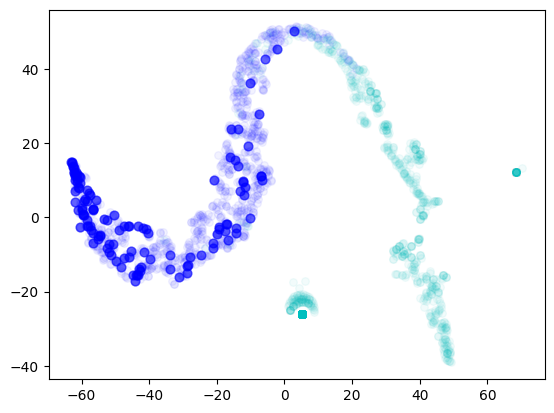

In [36]:
n = res['z_pos'].shape[0]
plt.scatter(zuvt[:n,0], zuvt[:n,1], s=30, c='b', alpha=0.05)
plt.scatter(zuvt[n:,0], zuvt[n:,1], s=30, c='c', alpha=0.05)

plt.scatter(zuvt[pos_indices,0], zuvt[pos_indices,1], s=40, c='b', alpha=0.6)

# check against baseline

In [38]:
# Extract edges from graphs[0] and graphs[1]
edges_0 = set(zip(graphs[0]['edge_index'][0], graphs[0]['edge_index'][1]))
edges_1 = set(zip(graphs[1]['edge_index'][0], graphs[1]['edge_index'][1]))

# Create a binary prediction for edges in graphs[1]
num_nodes = len(graphs[0]['user_to_idx'])
all_possible_edges = set((i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j)

# Positive edges
positive_edges = list(edges_1)
num_positive_edges = len(positive_edges)

# Negative edges: edges in all_possible_edges but not in edges_1
negative_edges = list(all_possible_edges - edges_1)
sampled_negative_edges = np.random.choice(len(negative_edges), num_positive_edges, replace=False)
negative_edges = [negative_edges[i] for i in sampled_negative_edges]

# Combine positive and sampled negative edges
all_edges = positive_edges + negative_edges
actual_labels = [1] * num_positive_edges + [0] * num_positive_edges
predicted_labels = [1 if edge in edges_0 else 0 for edge in all_edges]

# Convert to tensors
predicted_labels = torch.tensor(predicted_labels, dtype=torch.float)
actual_labels = torch.tensor(actual_labels, dtype=torch.float)

# Compute BCE loss
bce_loss = F.binary_cross_entropy(predicted_labels, actual_labels)
print(f"BCE Loss: {bce_loss.item()}")

BCE Loss: 49.519100189208984
